I study the apparent proper motion of radio sources to estimate the ICRF axis stability.

In [1]:
import matplotlib.pyplot as plt
# from matplotlib.ticker import MultipleLocator
import numpy as np
import statsmodels.api as sm
from astropy.table import Table, join

from statsmodels.iolib.table import (SimpleTable, default_txt_fmt)
import seaborn as sns

from my_progs.stat_func.rms_calc import rms_calc

In [2]:
icrf3_def = Table.read("../data/icrf3sx-def-sou.txt", format="ascii")

# 1 Distribution of the APM

In [3]:
apm_tab = Table.read("../logs/ts_pm_fit_3sigma.dat", format="ascii.csv")

# convert mas/yr into muas/yr
apm_tab["pmra"] = apm_tab["pmra"] * 1e3
apm_tab["pmra_err"] = apm_tab["pmra_err"] * 1e3
apm_tab["pmdec"] = apm_tab["pmdec"] * 1e3
apm_tab["pmdec_err"] = apm_tab["pmdec_err"] * 1e3

Remove sources without apparant proper motion estimate.

In [4]:
mask = apm_tab["num_cln"] >= 5
apm_tab = apm_tab[mask]

Estimate the empirical cumulative probability function.

In [5]:
ecdf_pmra = sm.distributions.ECDF(apm_tab["pmra"])
ecdf_pmdec = sm.distributions.ECDF(apm_tab["pmdec"])

For the ICRF3 defining sources.

In [6]:
apm_def = join(icrf3_def, apm_tab, keys="iers_name")

In [7]:
ecdf_pmra_def = sm.distributions.ECDF(apm_def["pmra"])
ecdf_pmdec_def = sm.distributions.ECDF(apm_def["pmdec"])

Make the plot.

In [8]:
bin_array = np.arange(-100, 100, 5)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


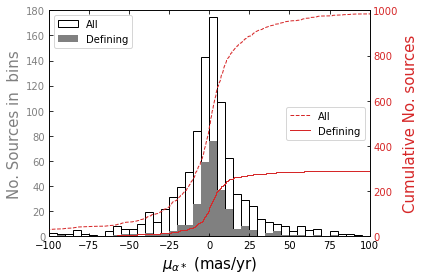

In [9]:
fig, ax1 = plt.subplots()

color = "grey"
ax1.hist(apm_tab["pmra"],
         bins=bin_array,
         color=color,
         fill=False,
         label="All")
ax1.hist(apm_def["pmra"],
         bins=bin_array,
         color=color,
         label="Defining")
ax1.set_xlabel("$\\mu_{\\alpha*}$ (mas/yr)", fontsize=15)
ax1.set_ylabel("No. Sources in  bins", color=color, fontsize=15)
ax1.tick_params(axis="y", labelcolor=color)
ax1.axis([-100, 100, 0, 180])
ax1.legend(loc="upper left")

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = "tab:red"
ax2.plot(ecdf_pmra.x,
         ecdf_pmra.y * len(apm_tab),
         color=color,
         lw=1,
         ls="--",
         label="All")
ax2.step(ecdf_pmra_def.x,
         ecdf_pmra_def.y * len(apm_def),
         color=color,
         lw=1,
         ls="-",
         label="Defining")
ax2.tick_params(axis="y", labelcolor=color)
ax2.set_ylabel("Cumulative No. sources", color=color,
               fontsize=15)  # we already handled the x-label with ax1
ax2.axis([-100, 100, 0, 1000])
ax2.legend(loc="center right")

plt.tight_layout()
plt.savefig("../plots/pmra-hist.eps")

In [65]:
per = [0, 5, 10, 25, 50, 75, 90, 95, 100] 
Q = np.percentile(apm_tab["pmra"], per)

line_fmt1 = "  {:8d}" * len(per)
line_fmt2 = "  {:8.2f}" * len(Q)

print("PM in R.A. (muas/yr)")
print("Percentile(%)", line_fmt1.format(*per))
print("             ", line_fmt2.format(*Q))

lim = 30
mask = (np.fabs(apm_tab["pmra"]) < lim)
print("[-{:2d}, {:2d}]: {:.2f}%".format(lim, lim, len(apm_tab[mask])/len(apm_tab)*100))

PM in R.A. (muas/yr)
Percentile(%)          0         5        10        25        50        75        90        95       100
                -1845.95    -57.63    -31.71     -9.97      0.70      9.65     29.01     54.79    736.67
[-30, 30]: 79.62%


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


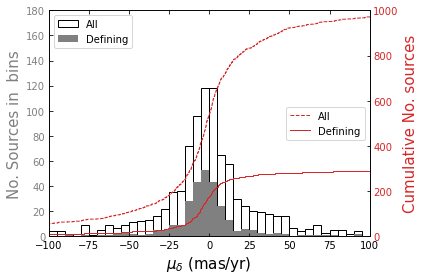

In [10]:
fig, ax1 = plt.subplots()


color = "grey"
ax1.hist(apm_tab["pmdec"],
         bins=bin_array,
         color=color,
         fill=False,
         label="All")
ax1.hist(apm_def["pmdec"],
         bins=bin_array,
         color=color,
         label="Defining")
ax1.set_xlabel("$\\mu_{\\delta}$ (mas/yr)", fontsize=15)
ax1.set_ylabel("No. Sources in  bins", color=color, fontsize=15)
ax1.tick_params(axis="y", labelcolor=color)
ax1.axis([-100, 100, 0, 180])
ax1.legend(loc="upper left")

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = "tab:red"
ax2.step(ecdf_pmdec.x,
         ecdf_pmdec.y * len(apm_tab),
         color=color,
         lw=1,
         ls="--",
         label="All")
ax2.step(ecdf_pmdec_def.x,
         ecdf_pmdec_def.y * len(apm_def),
         color=color,
         lw=1,
         ls="-",
         label="Defining")
ax2.tick_params(axis="y", labelcolor=color)
ax2.set_ylabel("Cumulative No. sources", color=color,
               fontsize=15)  # we already handled the x-label with ax1
ax2.axis([-100, 100, 0, 1000])
ax2.legend(loc="center right")

plt.tight_layout()
plt.savefig("../plots/pmdec-hist.eps")

In [64]:
per = [0, 5, 10, 25, 50, 75, 90, 95, 100] 
Q = np.percentile(apm_tab["pmdec"], per)

line_fmt1 = "  {:8d}" * len(per)
line_fmt2 = "  {:8.2f}" * len(Q)

print("PM in decl. (muas/yr)")
print("Percentile(%)", line_fmt1.format(*per))
print("             ", line_fmt2.format(*Q))

lim = 30
mask = (np.fabs(apm_tab["pmdec"]) < lim)
print("[-{:2d}, {:2d}]: {:.2f}%".format(lim, lim, len(apm_tab[mask])/len(apm_tab)*100))

PM in decl. (muas/yr)
Percentile(%)          0         5        10        25        50        75        90        95       100
                -2278.04   -107.89    -52.32    -14.94     -1.61     12.77     44.88     80.10   1949.62
[-30, 30]: 68.99%


In [11]:
mean_pmra = np.mean(apm_tab["pmra"])
median_pmra = np.median(apm_tab["pmra"])
std_pmra = np.std(apm_tab["pmra"])

mean_pmdec = np.mean(apm_tab["pmdec"])
median_pmdec = np.median(apm_tab["pmdec"])
std_pmdec = np.std(apm_tab["pmdec"])

/Users/Neo/scisoft/opt64/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:748: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [12]:
mean_pmra_def = np.mean(apm_def["pmra"])
median_pmra_def = np.median(apm_def["pmra"])
std_pmra_def = np.std(apm_def["pmra"])

mean_pmdec_def = np.mean(apm_def["pmdec"])
median_pmdec_def = np.median(apm_def["pmdec"])
std_pmdec_def = np.std(apm_def["pmdec"])

In [13]:
se = np.vstack([[len(apm_tab), mean_pmra, median_pmra, std_pmra],
                [len(apm_tab), mean_pmdec, median_pmdec, std_pmdec],
                [len(apm_def), mean_pmra_def, median_pmra_def, std_pmra_def],
                [len(apm_def), mean_pmdec_def, median_pmdec_def, std_pmdec_def]])

se = np.round(se, 5)

colnames = ["#sou", "Mean", "Median", "Std"]
rownames = ["All-RA", "All-Dec", "Def-RA", "Def-Dec"]

tabl = SimpleTable(se, colnames, rownames, txt_fmt=default_txt_fmt)
print(tabl)
print("Unit: muas/yr")

         #sou     Mean   Median    Std   
-----------------------------------------
All-RA  1006.0  -5.88117    0.7 107.71766
All-Dec 1006.0 -11.72768 -1.615 162.34737
Def-RA   290.0   2.10359   1.05  23.64274
Def-Dec  290.0  -7.04886  -2.97  41.63198
-----------------------------------------
Unit: muas/yr


# 2. Global spin from the ICRF3-defining source subset

In [14]:
from tool_func import vsh_fit_for_pm, vsh_fit_for_pm2

In [15]:
pmt, sig = vsh_fit_for_pm(apm_def)
pmt1, sig1 = vsh_fit_for_pm2(apm_def)

----------------------- VSH Fit (by Niu LIU) -----------------------

Pre-fit information:
    Number of sources                       290
    Maximum degree of VSH                     1
    Number of unknowns to determine           6
    Number of degree of freedom             573

No constraint is put on the data, so the fitting will be done only once.

Convert t_lm/s_lm at l=1 into rotation/glide vector
--------------------------------------------------------------------
           Glide [dex]                 Rotation [dex]   
  G1         G2        G3         R1         R2        R3       
--------------------------------------------------------------------
  +1    0    -0    0   -3    0    -1    0   +0    0    +1    0  
--------------------------------------------------------------------
----------------------- VSH Fit (by Niu LIU) -----------------------

Pre-fit information:
    Number of sources                       290
    Maximum degree of VSH                     1
    Numbe

In [16]:
se = np.vstack((pmt, sig, pmt1, sig1)).T
se = np.round(se, 5)

colnames = ["Full", "+/-", "Rotation", "+/-"]
rownames = ["Rx", "Ry", "Rz", "R"]

tabl = SimpleTable(se, colnames, rownames, txt_fmt=default_txt_fmt)
print(tabl)
print("Unit: muas/yr")
print("Number of sources used in the fitting is", len(apm_def))

     Full     +/-   Rotation   +/-  
------------------------------------
Rx -0.65347 0.40808 -0.70584 0.36422
Ry   0.2607 0.41389  0.53526   0.386
Rz  0.79945 0.28485  0.70165 0.29251
R   1.06495 0.64729  1.13005 0.60598
------------------------------------
Unit: muas/yr
Number of sources used in the fitting is 290


# 3 Global Spin from the whole sample

In [17]:
spin_tab = Table.read("../logs/spin_fit.txt", format="ascii")

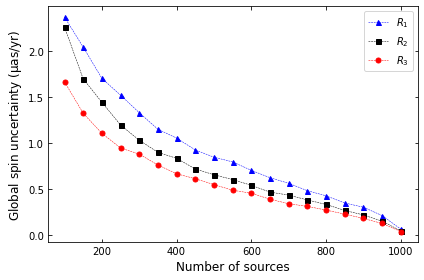

In [18]:
fig, ax = plt.subplots()

ax.plot(spin_tab["num_sou"],
         spin_tab["rx_std"],
         "b-^",
         ms=5,
         ls="--",
         lw=0.5,
         label="$R_1$")
ax.plot(spin_tab["num_sou"],
         spin_tab["ry_std"],
         "k-s",
         ms=5,
         ls="--",
         lw=0.5,
         label="$R_2$")
ax.plot(spin_tab["num_sou"],
         spin_tab["rz_std"],
         "r-o",
         ms=5,
         ls="--",
         lw=0.5,
         label="$R_3$")


ax.set_xlabel("Number of sources", fontsize=12)
ax.set_ylabel("Global spin uncertainty ($\mathrm{\mu as/yr}$)", fontsize=12)

# ax.axis([50, 1250, 0.3, 0.5])
ax.legend(bbox_to_anchor=(1., 1))

plt.tight_layout()


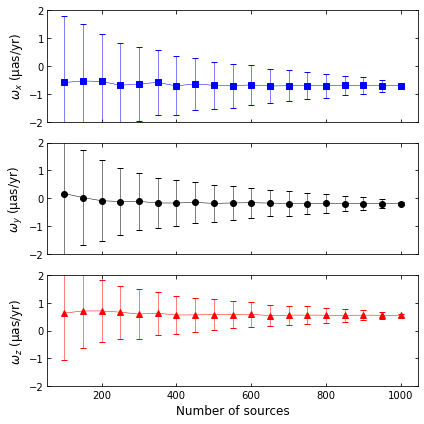

In [19]:
# fig, (ax0, ax1, ax2, ax3) = plt.subplots(figsize=(6, 8), nrows=4, sharex=True)
fig, (ax0, ax1, ax2) = plt.subplots(figsize=(6, 6), nrows=3, sharex=True, sharey=True)

ax0.errorbar(spin_tab["num_sou"],
             spin_tab["rx_mean"],
             yerr=spin_tab["rx_std"],
             color="blue",
             fmt="-s",
             elinewidth=0.5,
             lw=0.5,
             label="$R_1$",
             capsize=3)
ax1.errorbar(spin_tab["num_sou"],
             spin_tab["ry_mean"],
             yerr=spin_tab["ry_std"],
             color="black",
             fmt="-o",
             elinewidth=0.5,
             lw=0.5,
             label="$R_2$",
             capsize=3)
ax2.errorbar(spin_tab["num_sou"],
             spin_tab["rz_mean"],
             yerr=spin_tab["rz_std"],
             color="red",
             fmt="-^",
             elinewidth=0.5,
             lw=0.5,
             label="$R_3$",
             capsize=3)
# ax3.errorbar(spin_tab["num_sou"],
#              spin_tab["r_mean"],
#              yerr=spin_tab["r_std"],
#              color="green",
#              fmt="-v",
#              elinewidth=0.5,
#              lw=0.5,
#              label="$R$",
#              capsize=3)

ax2.set_ylim([-2, 2])

ax2.set_xlabel("Number of sources", fontsize=12)
# ax3.set_xlabel("Number of sources", fontsize=12)
ax0.set_ylabel("$\\omega_x$ ($\mathrm{\mu as/yr}$)", fontsize=12)
ax1.set_ylabel("$\\omega_y$ ($\mathrm{\mu as/yr}$)", fontsize=12)
ax2.set_ylabel("$\\omega_z$ ($\mathrm{\mu as/yr}$)", fontsize=12)
# ax3.set_ylabel("$\\omega$ ($\mathrm{\mu as/yr}$)", fontsize=12)

plt.tight_layout()
plt.savefig("../plots/spin-from-apm.eps")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


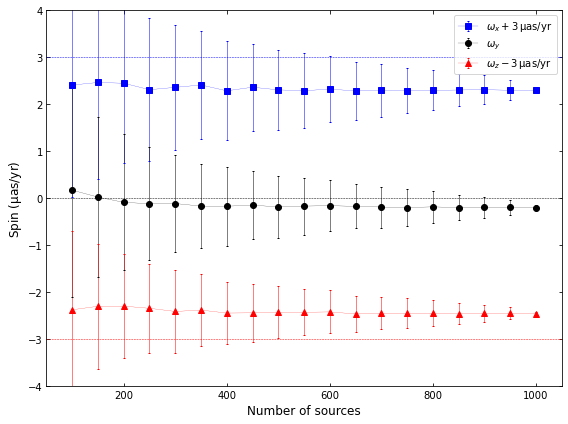

In [67]:
# fig, (ax0, ax1, ax2, ax3) = plt.subplots(figsize=(6, 8), nrows=4, sharex=True)
fig, ax = plt.subplots(figsize=(8, 6))

ax.hlines(3, 50, 1050, ls="dashed", color="b", lw=0.5)
ax.hlines(0, 50, 1050, ls="dashed", color="k", lw=0.5)
ax.hlines(-3, 50, 1050, ls="dashed", color="r", lw=0.5)

ax.errorbar(spin_tab["num_sou"],
             spin_tab["rx_mean"]+3,
             yerr=spin_tab["rx_std"],
             color="blue",
             fmt="-s",
             elinewidth=0.5,
             lw=0.2,
             label="$\\omega_x+3\,\mathrm{\mu as/yr}$",
             capsize=1)
ax.errorbar(spin_tab["num_sou"],
             spin_tab["ry_mean"],
             yerr=spin_tab["ry_std"],
             color="black",
             fmt="-o",
             elinewidth=0.5,
             lw=0.2,
             label="$\\omega_y$",
             capsize=1)
ax.errorbar(spin_tab["num_sou"],
             spin_tab["rz_mean"]-3,
             yerr=spin_tab["rz_std"],
             color="red",
             fmt="-^",
             elinewidth=0.5,
             lw=0.2,
             label="$\\omega_z-3\,\mathrm{\mu as/yr}$",
             capsize=1)


ax.axis([50, 1050, -4, 4])

ax.set_xlabel("Number of sources", fontsize=12)
ax.set_ylabel("Spin ($\mathrm{\mu as/yr}$)", fontsize=12)

ax.legend()

plt.tight_layout()
plt.savefig("../plots/spin-from-apm.eps")

In [20]:
rx_q1q3 = np.vstack((spin_tab["rx_q2"] - spin_tab["rx_q1"],
                     spin_tab["rx_q3"] - spin_tab["rx_q2"]))
ry_q1q3 = np.vstack((spin_tab["ry_q2"] - spin_tab["ry_q1"],
                     spin_tab["ry_q3"] - spin_tab["ry_q2"]))
rz_q1q3 = np.vstack((spin_tab["rz_q2"] - spin_tab["rz_q1"],
                     spin_tab["rz_q3"] - spin_tab["rz_q2"]))
r_q1q3 = np.vstack((spin_tab["r_q2"] - spin_tab["r_q1"],
                    spin_tab["r_q3"] - spin_tab["r_q2"]))

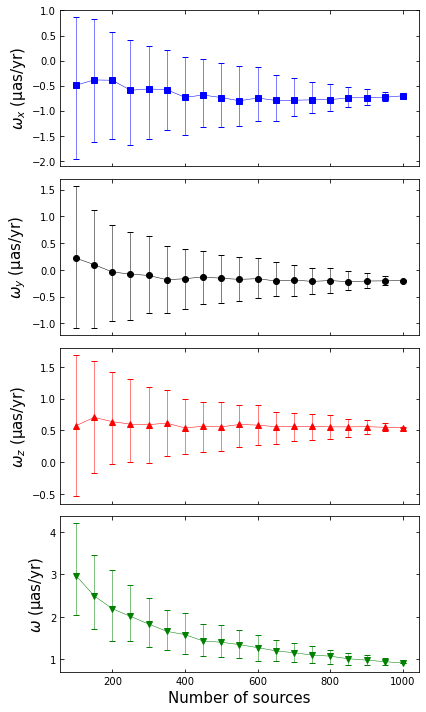

In [21]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(figsize=(6, 10), nrows=4, sharex=True)

ax0.errorbar(spin_tab["num_sou"],
             spin_tab["rx_q2"],
             yerr=rx_q1q3,
             color="blue",
             fmt="-s",
             elinewidth=0.5,
             lw=0.5,
             label="$R_1$",
             capsize=3)
ax1.errorbar(spin_tab["num_sou"],
             spin_tab["ry_q2"],
             yerr=ry_q1q3,
             color="black",
             fmt="-o",
             elinewidth=0.5,
             lw=0.5,
             label="$R_2$",
             capsize=3)
ax2.errorbar(spin_tab["num_sou"],
             spin_tab["rz_q2"],
             yerr=rz_q1q3,
             color="red",
             fmt="-^",
             elinewidth=0.5,
             lw=0.5,
             label="$R_3$",
             capsize=3)
ax3.errorbar(spin_tab["num_sou"],
             spin_tab["r_q2"],
             yerr=r_q1q3,
             color="green",
             fmt="-v",
             elinewidth=0.5,
             lw=0.5,
             label="$R$",
             capsize=3)

ax3.set_xlabel("Number of sources", fontsize=15)
ax0.set_ylabel("$\\omega_x$ ($\mathrm{\mu as/yr}$)", fontsize=15)
ax1.set_ylabel("$\\omega_y$ ($\mathrm{\mu as/yr}$)", fontsize=15)
ax2.set_ylabel("$\\omega_z$ ($\mathrm{\mu as/yr}$)", fontsize=15)
ax3.set_ylabel("$\\omega$ ($\mathrm{\mu as/yr}$)", fontsize=15)

plt.tight_layout()
# plt.savefig("../plots/spin-from-apm.eps")

In [30]:
wmean1, wrms1, wstd1 = rms_calc(spin_tab["rx_mean"])
wmean2, wrms2, wstd2 = rms_calc(spin_tab["ry_mean"])
wmean3, wrms3, wstd3 = rms_calc(spin_tab["rz_mean"])

print("No weighted")
print("    Mean    RMS   Std")
print("   uas/yr uas/yr uas/yr")
print("R1  {:+4.2f}   {:4.2f}   {:.2f}".format(wmean1, wrms1, wstd1))
print("R2  {:+4.2f}   {:4.2f}   {:.2f}".format(wmean2, wrms2, wstd2))
print("R3  {:+4.2f}   {:4.2f}   {:.2f}".format(wmean3, wrms3, wstd3)) 

No weighted
    Mean    RMS   Std
   uas/yr uas/yr uas/yr
R1  -0.66   0.68   0.06
R2  -0.14   0.17   0.09
R3  +0.59   0.61   0.05


In [31]:
wmean1, wrms1, wstd1 = rms_calc(spin_tab["rx_mean"], spin_tab["rx_std"])
wmean2, wrms2, wstd2 = rms_calc(spin_tab["ry_mean"], spin_tab["ry_std"])
wmean3, wrms3, wstd3 = rms_calc(spin_tab["rz_mean"], spin_tab["rz_std"])

print("Weighted")
print("    Mean   WRMS   Std")
print("   uas/yr uas/yr uas/yr")
print("R1  {:+4.2f}   {:4.2f}   {:.2f}".format(wmean1, wrms1, wstd1))
print("R2  {:+4.2f}   {:4.2f}   {:.2f}".format(wmean2, wrms2, wstd2))
print("R3  {:+4.2f}   {:4.2f}   {:.2f}".format(wmean3, wrms3, wstd3)) 

Weighted
    Mean   WRMS   Std
   uas/yr uas/yr uas/yr
R1  -0.70   0.70   0.01
R2  -0.19   0.19   0.01
R3  +0.55   0.55   0.01


Consider the time span of J1979.59 - J2021.15.

In [70]:
dt = 2021.15 - 1979.59
spin = 0.8

print("Spin : {:.1f} muas/yr".format(spin))
print("Time span : {:.1f} yr".format(dt))
print("Deformation : {:.1f} muas".format(spin*dt))

Spin : 0.8 muas/yr
Time span : 41.6 yr
Deformation : 33.2 muas
